In [1]:
import kagglehub
from sklearn.model_selection import train_test_split

# List all files in the dataset
dataset_path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
print(dataset_path)  # See where it’s stored locally

import os
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        print(f)


C:\Users\ibuko\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
amazon_review_polarity_csv.tgz
test.csv
train.csv


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
import keras_nlp

In [3]:
print('\\'.join(dataset_path.split('\\')[:-1])+'\\train.csv')

C:\Users\ibuko\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\train.csv


In [4]:
df = pd.read_csv('\\'.join(dataset_path.split('\\')[:-1])+'\\2\\train.csv', header=None)

In [5]:
df.columns

Index([0, 1, 2], dtype='int64')

In [6]:
df.head()

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [7]:
val_df = pd.read_csv('\\'.join(dataset_path.split('\\')[:-1])+'\\2\\test.csv', header=None)


In [8]:
df.rename(columns={0:'polarity', 1:'title',2:'text'}, inplace=True)
val_df.rename(columns={0:'polarity', 1:'title',2:'text'}, inplace=True)


In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   text      object
dtypes: int64(1), object(2)
memory usage: 1.8 GB


In [10]:
len(df['text'].max())

111

In [11]:
df['combined_text'] = df['title'] + ' ' + df['text']
val_df['combined_text'] = val_df['title'] + ' ' + val_df['text']

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [13]:
val_df.iloc[0]

polarity                                                         2
title                                                     Great CD
text             My lovely Pat has one of the GREAT voices of h...
combined_text    Great CD My lovely Pat has one of the GREAT vo...
Name: 0, dtype: object

In [14]:
import re
import string

def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    text = text.replace('""','"')
    text = re.sub(r'\s+', ' ',text)
    text = re.sub(r'[^\w\s.,!?\'"-]', '', text)
    text = text.lower().strip()
    return text

In [15]:
df['combined_text'] = df['combined_text'].apply(clean_text)
val_df['combined_text'] = val_df['combined_text'].apply(clean_text)

In [16]:
df['word_count'] = df['combined_text'].str.split().str.len()
val_df['word_count'] = val_df['combined_text'].str.split().str.len()

print(f'''Numbers of words''')
print(f'''Mean: {df['word_count'].mean()}''')
print(f'''Median: {df['word_count'].median()}''')
print(f'''Min: {df['word_count'].min()}''')
print(f'''Max: {df['word_count'].max()}''')
print(f'''75 percentile: {df['word_count'].quantile(q=.75)}''')
print(f'''95 percentile: {df['word_count'].quantile(q=.95)}''')

Numbers of words
Mean: 78.4037025
Median: 70.0
Min: 0
Max: 257
75 percentile: 108.0
95 percentile: 161.0


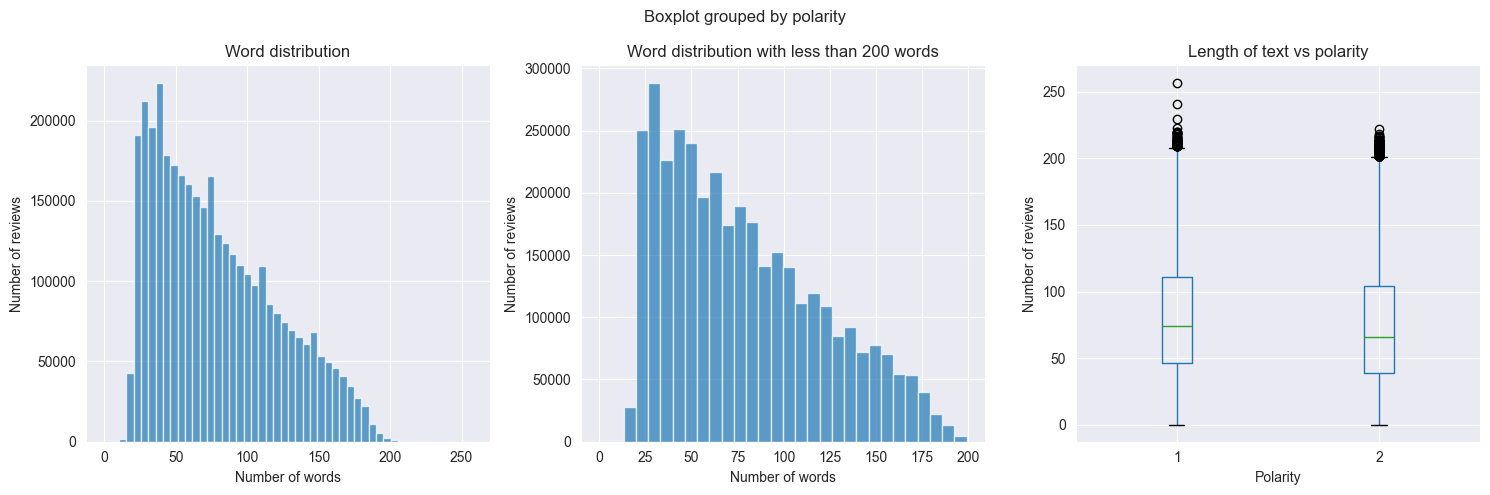

161


In [17]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
df['word_count'].hist(bins=50, alpha=0.7)
plt.title('Word distribution')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')

plt.subplot(1,3,2)
df['word_count'][df['word_count']<200].hist(bins=30,alpha=0.7)
plt.title('Word distribution with less than 200 words')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')

plt.subplot(1,3,3)
df.boxplot(column='word_count',by='polarity',ax=plt.gca())
plt.title('Length of text vs polarity')
plt.xlabel('Polarity')
plt.ylabel('Number of reviews')

plt.tight_layout()
plt.show()
recommended_max_length = int(df['word_count'].quantile(0.95))
print(recommended_max_length)

In [18]:
df.columns

Index(['polarity', 'title', 'text', 'combined_text', 'word_count'], dtype='object')

In [19]:
# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 20000
MAX_LENGTH = recommended_max_length

PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'
VOCAB_SIZE = 20000
SEQ_LEN = 128
OOV_TOKEN = '<OOV>'

X_train,X_val, y_train,y_val = train_test_split(
    df['combined_text'],
    df['polarity'],
    test_size=0.2,
    random_state=42,
    stratify=df['polarity']

)
X_test = val_df['combined_text']
y_test = val_df['polarity']

print(f"Training: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test: {len(X_test)}")


print(f"\nClass distribution- Train: {np.bincount(y_train)}")
print(f"Class distribution - Val: {np.bincount(y_val)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Training: 2880000 (80.0%)
Validation: 720000 (20.0%)
Test: 400000

Class distribution- Train: [      0 1440000 1440000]
Class distribution - Val: [     0 360000 360000]
Class distribution - Test: [     0 200000 200000]


In [20]:
df.iloc[0]

polarity                                                         2
title                               Stuning even for the non-gamer
text             This sound track was beautiful! It paints the ...
combined_text    stuning even for the non-gamer this sound trac...
word_count                                                      80
Name: 0, dtype: object

In [21]:
y_train_binary = y_train-1
y_val_binary = y_val -1
y_test_binary = y_test-1

In [22]:
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token=OOV_TOKEN,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
all_texts = pd.concat([X_train, X_val, X_test])
print(f'''Training on {len(all_texts)} reviews''')
tokenizer.fit_on_texts(all_texts)

print(f'''Size of vocabulary: {len(tokenizer.word_index)}''')
print(f'''Used size of vocabulary: {min(len(tokenizer.word_index),VOCAB_SIZE)}''')

print(f''' Top 50 the most common words ''')
for word,index in list(tokenizer.word_index.items())[:50]:
    print(f'''{word} : {index}''')


sample_text = X_train.iloc[0]
sample_token = tokenizer.texts_to_sequences([sample_text])[0]

print(f'''Sample of tokenization''')
print(f'''Text: {sample_text[:100]}''')
print(f'''Token: {sample_token[:20]}''')
print(f'''Number of tokens: {len(sample_token)}''')


Training on 4000000 reviews
Size of vocabulary: 1408060
Used size of vocabulary: 20000
 Top 50 the most common words 
<OOV> : 1
the : 2
and : 3
i : 4
a : 5
to : 6
it : 7
of : 8
this : 9
is : 10
in : 11
for : 12
that : 13
was : 14
not : 15
you : 16
but : 17
with : 18
on : 19
book : 20
have : 21
my : 22
as : 23
are : 24
one : 25
be : 26
so : 27
all : 28
if : 29
great : 30
very : 31
good : 32
like : 33
they : 34
at : 35
just : 36
from : 37
or : 38
would : 39
out : 40
about : 41
an : 42
me : 43
has : 44
what : 45
more : 46
had : 47
will : 48
read : 49
when : 50
Sample of tokenization
Text: finally- a good gold! i have been looking for a great gold spraypaint and have found that it's very 
Token: [433, 5, 32, 1723, 4, 21, 88, 188, 12, 5, 30, 1723, 1, 3, 21, 150, 13, 51, 31, 460]
Number of tokens: 50
